<a href="https://colab.research.google.com/github/arjunks25/CancerDetectionAI/blob/main/CancerDetectionAIPresentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
from torchvision import models

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the ResNet-18 model
model = models.resnet18(pretrained=False)

# Modify the classifier to match the number of classes (4 in your case)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

# Load the state_dict from the saved checkpoint (replace the path with the actual path)
checkpoint_path = '/content/drive/My Drive/brain_tumor_model_resnet18.pth'
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
import zipfile

with zipfile.ZipFile('/content/drive/My Drive/BrainMRIDataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os

# Define data transformations, including data augmentation
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Define data directories
data_dir = '/content'
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Testing')

# Create data loaders for the training and testing datasets
batch_size = 32

train_dataset = datasets.ImageFolder(train_dir, transform=transform['train'])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.ImageFolder(test_dir, transform=transform['test'])
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Map class labels to cancer types
class_names = {
    0: 'Glioma Tumor',
    1: 'Meningioma Tumor',
    2: 'No Tumor',
    3: 'Pituitary Tumor'
}



# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Add weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Define a learning rate scheduler for better training
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Early stopping parameters
early_stopping = 1  # Number of epochs without improvement to wait before stopping
best_accuracy = 0.0  # Track the best accuracy
wait = 0  # Counter for early stopping

In [5]:
# Test the model and calculate accuracy
model.eval()
correct = [0, 0, 0, 0]  # Initialize class-specific correct predictions
total = [0, 0, 0, 0]  # Initialize class-specific total predictions

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
             label = labels[i]
             correct[label] += c[i].item()
             total[label] += 1

overall_accuracy = 100 * sum(correct) / sum(total)

if overall_accuracy > best_accuracy:
     best_accuracy = overall_accuracy
     wait = 0  # Reset the counter
else:
    wait += 1  # Increment the counter

print(f'Overall Accuracy on the test set: {overall_accuracy:.2f}%')

for i in range(4):
    class_accuracy = 100 * correct[i] / total[i]
    cancer_type = class_names[i]
    print(f'Accuracy for {cancer_type}: {class_accuracy:.2f}%')




print('Finished Testing')

Overall Accuracy on the test set: 99.31%
Accuracy for Glioma Tumor: 97.67%
Accuracy for Meningioma Tumor: 100.00%
Accuracy for No Tumor: 100.00%
Accuracy for Pituitary Tumor: 99.33%
Finished Testing


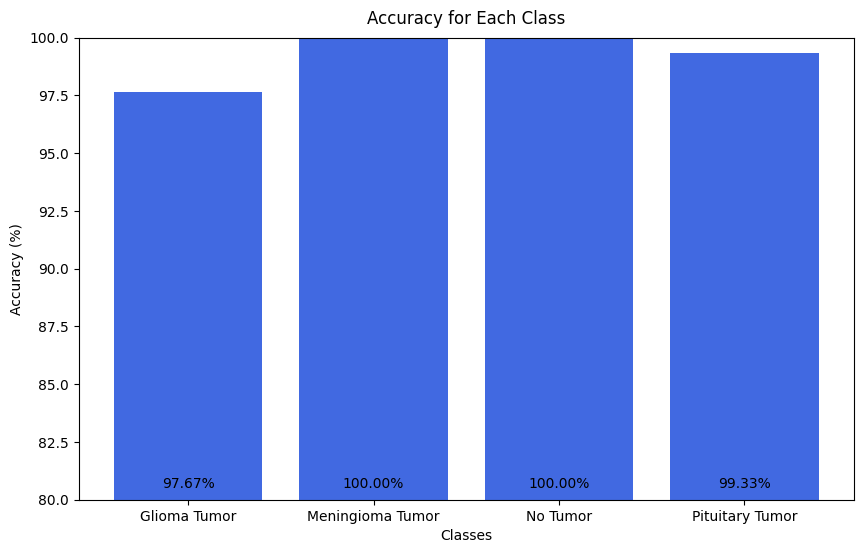

In [34]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define a dictionary to map class indices to class names
class_names = {
    0: 'Glioma Tumor',
    1: 'Meningioma Tumor',
    2: 'No Tumor',
    3: 'Pituitary Tumor'
}
accuracies=np.array(correct)/np.array(total)*100

model.eval()

# Create a bar graph to visualize class accuracies
plt.figure(figsize=(10, 6))
plt.bar(class_names.values(), accuracies, color='royalblue')
plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for Each Class',pad=10)
plt.ylim(80, 100)


for i in range(4):
    class_accuracy = 100 * correct[i] / total[i]
    cancer_type = class_names[i]
    plt.text(i, 80.5, f'{class_accuracy:.2f}%', ha='center')


plt.show()

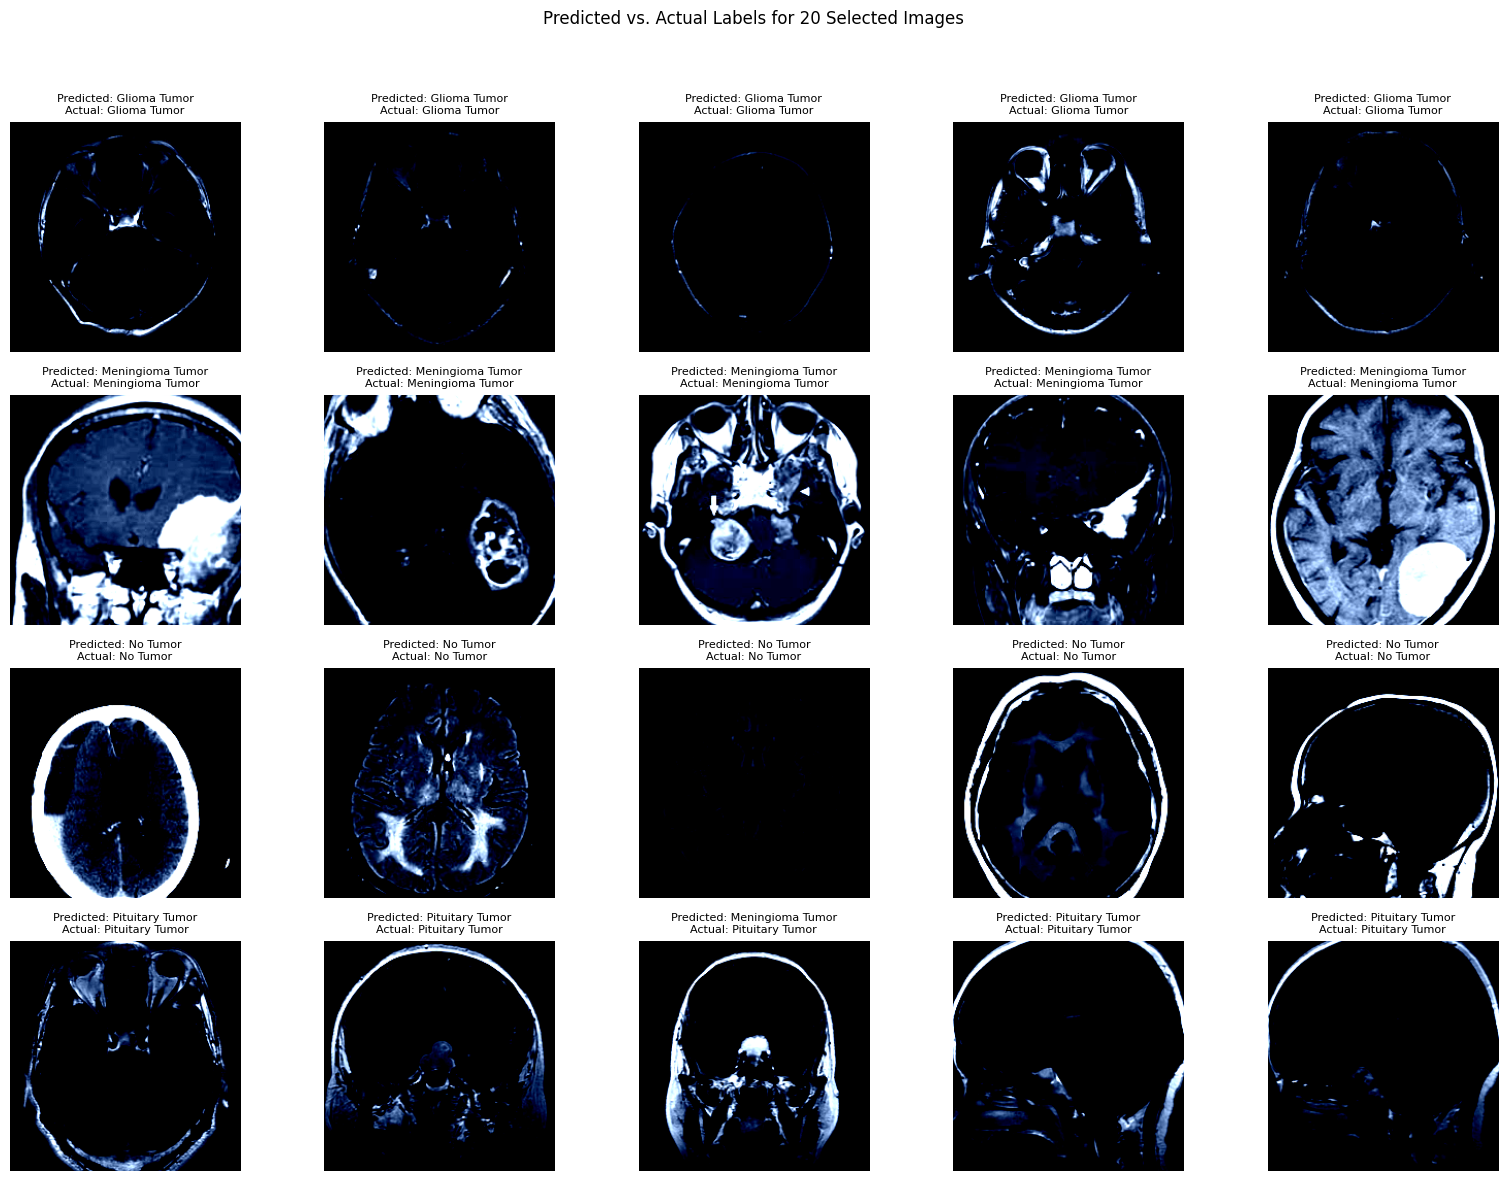

In [33]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a trained model (model) and a test data loader (test_loader) from the previous code

# Define a dictionary to map class indices to class names
class_names = {
    0: 'Glioma Tumor',
    1: 'Meningioma Tumor',
    2: 'No Tumor',
    3: 'Pituitary Tumor'
}

model.eval()

# Initialize lists to store selected images and labels
selected_images = []
selected_labels = []

# Iterate through the test dataset and select one image from each class
class_count = [0] * 4

for images, labels in test_loader:
    for image, label in zip(images, labels):
        if class_count[label] < 5:  # Select up to 5 images from each class
            selected_images.append(image)
            selected_labels.append(label)
            class_count[label] += 1

            if sum(class_count) == 20:  # If we have 5 images from each class
                break

# Display the 20 selected images along with their predicted and actual labels
fig, axs = plt.subplots(4, 5, figsize=(16, 12))
fig.suptitle('Predicted vs. Actual Labels for 20 Selected Images')

for i in range(20):
    image = selected_images[i].numpy()
    with torch.no_grad():
        outputs = model(selected_images[i].unsqueeze(0))  # Make a batch of size 1
        _, predicted = torch.max(outputs, 1)

    predicted_label = class_names[predicted.item()]
    actual_label = class_names[selected_labels[i].item()]

    axs[i // 5, i % 5].imshow(np.transpose(image, (1, 2, 0)))
    axs[i // 5, i % 5].set_title(f'Predicted: {predicted_label}\nActual: {actual_label}', fontsize=8)  # Adjust fontsize
    axs[i // 5, i % 5].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Add this line to prevent overlap
plt.show()
